# Мое решение Задачи 2 "Спрос на бронирование отелей"

Я работаю на удаленном сервер с ГПУ через VS code. Поэтому у меня нет кода который загружает или скачивает данные с Google Colab.

Данные содержат сведения о спросе на отели. Датасет содержит 119 390 наблюдений. Каждое наблюдение представляет собой бронирование отеля. Набор данных учитывает бронирования, которые должны прибыть в период с 1 июля 2015 года по 31 августа 2017 года, включая фактически поступившие и отмененные бронирования.

Данные содержат сведения о **70 146** отелях.
- Тренировочный набор - **44 634 строк**.
- Тестовый набор - **25 512 строк**.

In [1]:
# установим AutoML фреймворк от Сбера - LightAutoML(LAMA)
# это позволит довольно быстро проверять различные гипотезы и 
# отбирать лучшие решения.
# !pip install -U lightautoml

In [2]:
# иморитирование всех необходимых библиотек
import os

import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# импорты из LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Считывание данных

In [3]:
# Считываем тренировочные данные
train = pd.read_csv("./train.csv")

print(f"Train dataset shape: {train.shape}")

Train dataset shape: (5282, 20)


In [4]:
# Считываем тестовые данные
test = pd.read_csv("./test.csv")

print(f"Test dataset shape: {test.shape}")

Test dataset shape: (1761, 19)


In [5]:
# Посмотрим как выглядят данные
train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


## Исследование данных

Прежде чем переходить к непосредственному построению модели, в первую очередь необходимо исследовать имеющихся у вас набор данных:
1. Какую задачу вы решаете (классификация, регрессия) и какая переменная является целевой?
2. Сколько переменных в данных и какого они типа?
3. Имеются ли в данных пропуски?

In [6]:
print("Number of missing values in train dataset:")
print(train.isna().sum())
print("Number of missing values in test dataset:")
print(test.isna().sum())

Number of missing values in train dataset:
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64
Number of missing values in test dataset:
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
Ha

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

**Проверим баланс классов.**

В задаче классификации данные называются несбалансированными (Imbalanced Data), если в обучающей выборке доли объектов разных классов существенно различаются, также говорят, что «классы не сбалансированы».

In [8]:
train['Churn'].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

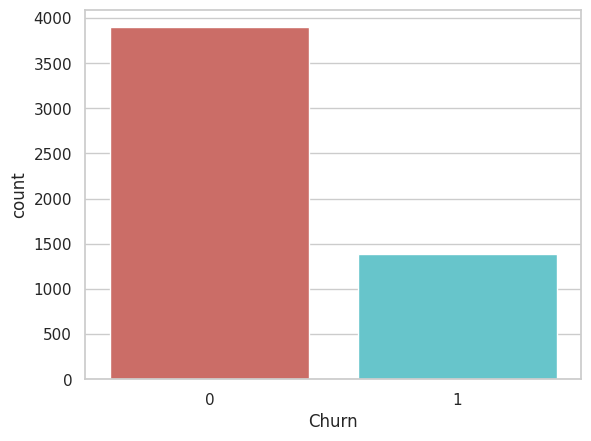

In [9]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
y_data = pd.DataFrame(train['Churn'])
sns.countplot(x='Churn', data=y_data, palette='hls')
plt.show()

## Предобработка данных

Исходя из анализа данных, можно сделать выводы:
- в данных пропусков нет
- в данных имеются категориальные признаки
- в задаче решается задача бинарной классификации
- существует небольшой дисбаланс классов отмененных бронирований отелей (класс 1) примерно в два раза меньше, чем неотмененных (класс 2).
Это хорошо для владельцев отелей, но может создать некоторый bias в нашей модели.
Однако итоговая метрика соревнования accuracy, данная метрика не учитывает дисбаланс классов.

### Кодирование признаков

**Категориальные признаки называют по-разному: факторными, номинальными.**

Их значения определяют факт принадлежности к какой-то категории. Примеры таких признаков: пол, страна проживания, номер группы, категория товаров и т.п. Ясно, что для компьютерной обработки вместо «понятного для человека» значения (в случае страны — ‘Russia’, ‘GB’, ‘France’ и т.п.) хранят числа. 

**Категориальные** признаки называют по-разному: **факторными**, **номинальными**. Их значения определяют факт принадлежности к какой-то категории. 

Примеры таких признаков: пол, страна проживания, номер группы, категория товаров и т.п. Ясно, что для компьютерной обработки вместо «понятного для человека» значения (в случае страны — ‘Russia’, ‘GB’, ‘France’ и т.п.) хранят числа.

In [10]:
# Перечислим колонки которые являются категоритальными признаками
# выбрали датафраме test, чтобы в списке признаков не было целевой переменной

# Категориальные признаки
category_features = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

In [11]:
# Перечислим колонки которые являются количественными(числовыми) признаками
# выбрали датафраме test, чтобы в списке признаков не было целевой переменной

numeric_features = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

In [12]:
# конвертируем строки во float
train['TotalSpent'] = pd.to_numeric(train['TotalSpent'].replace('', np.nan).replace(' ',np.nan))
test['TotalSpent'] = pd.to_numeric(test['TotalSpent'].replace('', np.nan).replace(' ',np.nan))

У используемой мной библиотеки lightAutoLM от Сбера есть своя встроенная обработка категориальных данных.
Нам нужно пр постановке задачи просто указать какие колонки являются количественными(числовыми), а какие категориальными.
Что мы и сделаем.

Бывает, что распределения числовых признаков в предоставленных данных могут сильно отличаться.
Например, некоторый параметр "цена бронирования" имеет в train выборе распределение от 0 до 1000, а в тесте от 5000 до 10000.
Таким образом модель обученная по выборке train будет работать в диапазоне значений который не встречается в test выборке.
Простейший способ борьбы с этим явлением - избавиться от такого признака при обучении модели.

/tmp/ipykernel_1816773/3591886276.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[[col_i]], hist=False)
/tmp/ipykernel_1816773/3591886276.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[[col_i]], hist=False)


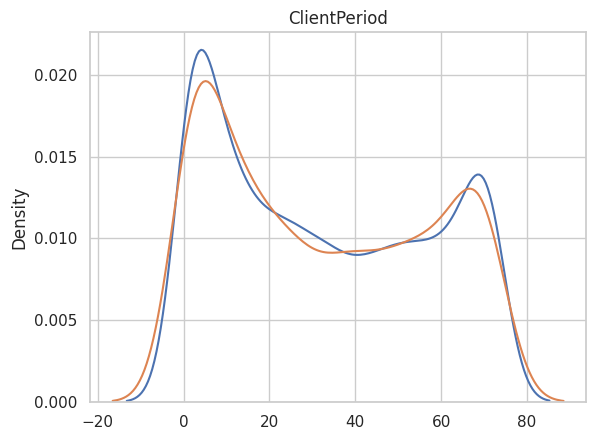

/tmp/ipykernel_1816773/3591886276.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[[col_i]], hist=False)
/tmp/ipykernel_1816773/3591886276.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[[col_i]], hist=False)


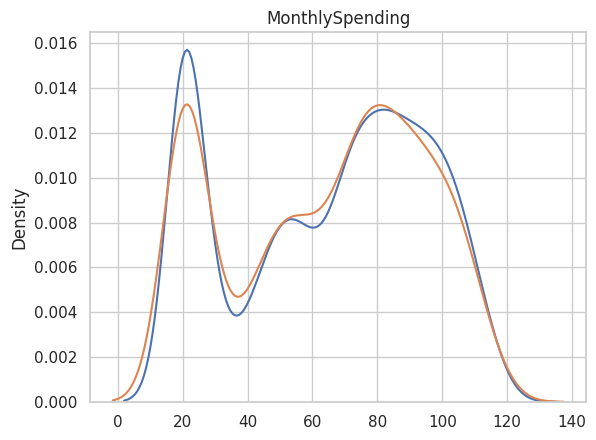

/tmp/ipykernel_1816773/3591886276.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[[col_i]], hist=False)
/tmp/ipykernel_1816773/3591886276.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[[col_i]], hist=False)


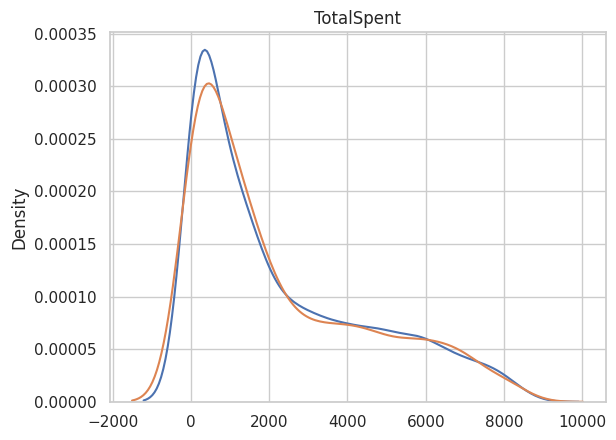

/tmp/ipykernel_1816773/3591886276.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[[col_i]], hist=False)
/tmp/ipykernel_1816773/3591886276.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[[col_i]], hist=False)


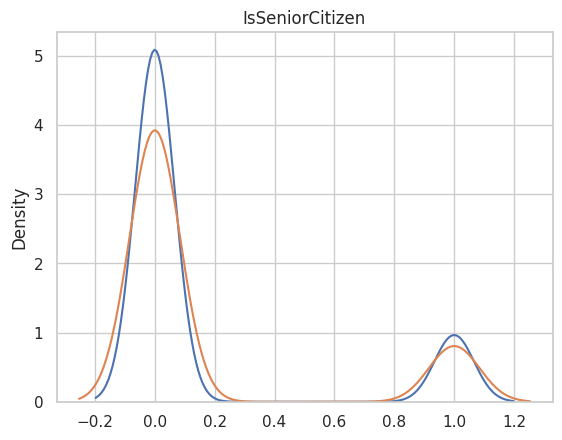

In [13]:
# Мы хотим посмотреть распределения значений у количественных признаков между выборками train и test

for col_i in test.loc[:, train.dtypes != object].columns:
    sns.distplot(train[[col_i]], hist=False)
    sns.distplot(test[[col_i]], hist=False)
    plt.title(col_i)
    plt.show()

## Вывод -  выборки train и test гомогенны
Мы видим, что распределения очень похожи а выборки train и test - гомогенны. Можно работать со всеми числовыми признаками )

## Разделяем train-выборку на train (80%) и val(20%)

In [14]:
# Разобьем выборку на обучающую и валидационную
tr_data, valid_data = train_test_split(train, 
                                       test_size=0.2, 
                                       stratify=train['Churn'], 
                                       random_state=42)

print(f'Parts sizes: tr_data = {tr_data.shape}, valid_data = {valid_data.shape}')

Parts sizes: tr_data = (4225, 20), valid_data = (1057, 20)


## Обучение модели

Теперь наши данные готовы для обучения модели.

## Ставим задачу машинного обучения используем все

In [15]:
# https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task
task = Task('binary', loss= 'logloss', metric = 'auc')

In [16]:
category_features

['Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod']

In [17]:
numeric_features

['ClientPeriod', 'MonthlySpending', 'TotalSpent']

In [18]:
roles = {'target': 'Churn',
         'numeric': numeric_features,
         'category': category_features
         }

In [19]:
automl = TabularAutoML(
    task = task, 
    timeout = 3600 * 3, # 3600 секунд = 1 час
    reader_params = {'n_jobs': 12, 'cv': 3, 'random_state': 42},
    general_params = {'use_algos': [['lgb', 'cb', 'linear_l2']]},
    timing_params ={'mode': 0}
                    )

In [20]:
# запускаем обучение на данных и подбор оптимальных параметров
# из ансамбля моделей
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose=4)

[03:04:15] Stdout logging level is DEBUG.
[03:04:15] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[03:04:15] Task: binary

[03:04:15] Start automl preset with listed constraints:
[03:04:15] - time: 10800.00 seconds
[03:04:15] - CPU: 4 cores
[03:04:15] - memory: 16 GB

[03:04:15] Train data shape: (4225, 20)

[03:04:17] Feats was rejected during automatic roles guess: []
[03:04:17] Layer 1 train process start. Time left 10798.43 secs
[03:04:17] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[03:04:17] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [29, 30, 31, 32, 33], 'embed_sizes': array([3, 4, 3, 4, 3], dtype=int32), 'data_size': 34}
[03:04:17] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[03:04:17] Linear model: C = 1e-05 score = 0.803

/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/li

[03:04:17] Linear model: C = 0.005 score = 0.8514488221805295
[03:04:17] Linear model: C = 0.01 score = 0.85291588492808
[03:04:17] Linear model: C = 0.05 score = 0.8548650198040443
[03:04:17] Linear model: C = 0.1 score = 0.855120387742339
[03:04:17] Linear model: C = 0.5 score = 0.8547425474254742
[03:04:17] Linear model: C = 1 score = 0.8547425474254742
[03:04:17] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[03:04:17] Linear model: C = 1e-05 score = 0.7979060541327262
[03:04:17] Linear model: C = 5e-05 score = 0.8051832202633864
[03:04:17] Linear model: C = 0.0001 score = 0.8098885993672256
[03:04:17] Linear model: C = 0.0005 score = 0.8234961175405786
[03:04:17] Linear model: C = 0.001 score = 0.826853003852464
[03:04:17] Linear model: C = 0.005 score = 0.8315218667104861
[03:04:17] Linear model: C = 0.01 score = 0.8327373360355355
[03:04:17] Linear model: C = 0.05 score = 0.8355047458078045
[03:04:17] Linear model: C = 0.1 score = 0.8366550075510378
[03:0

/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/li

[03:04:17] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[03:04:17] Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 4, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
[03:04:17] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[03:04:17] Training until validation scores don't improve for 200 rounds
[03:04:17] [100]	valid's auc: 0.834687
[03:04:18] [200]	valid's auc: 0.838645
[03:04:18] [300]	valid's auc: 0.840003
[03:04:18] [400]	valid's auc: 0.840781
[03:04:18] [500]	valid's auc: 0.840981
[03:04:18] [600]	valid's auc: 0.840253
[03:04:18] Early stopping, best iteration is:
[414]	valid's auc: 0.841211
[03:04:18] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[

/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/li

[03:04:18] [100]	valid's auc: 0.83367
[03:04:18] [200]	valid's auc: 0.834403
[03:04:18] [300]	valid's auc: 0.835241
[03:04:18] [400]	valid's auc: 0.834491
[03:04:18] [500]	valid's auc: 0.834804
[03:04:18] Early stopping, best iteration is:
[305]	valid's auc: 0.835468
[03:04:18] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[03:04:18] Training until validation scores don't improve for 200 rounds
[03:04:18] [100]	valid's auc: 0.831514
[03:04:18] [200]	valid's auc: 0.831166
[03:04:18] Early stopping, best iteration is:
[15]	valid's auc: 0.833336
[03:04:18] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8082447229218925
[03:04:18] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[03:04:18] Start fitting Lvl_0_Pipe_1_Mod_1_CatBoost ...
[03:04:18] Training params: {'task_type': 'GPU', 'thread_count': 4, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'm

Default metric period is 5 because AUC is/are not implemented for GPU


[03:04:18] 100:	test: 0.8448483	best: 0.8454776 (70)	total: 223ms	remaining: 882ms
[03:04:18] bestTest = 0.8454776406
[03:04:18] bestIteration = 70
[03:04:18] Shrink model to first 71 iterations.
[03:04:18] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_CatBoost =====
[03:04:19] 0:	test: 0.8003852	best: 0.8003852 (0)	total: 2.48ms	remaining: 1.24s


Default metric period is 5 because AUC is/are not implemented for GPU


[03:04:19] 100:	test: 0.8337885	best: 0.8345553 (77)	total: 217ms	remaining: 858ms
[03:04:19] 200:	test: 0.8358451	best: 0.8359860 (195)	total: 450ms	remaining: 669ms
[03:04:20] 300:	test: 0.8352700	best: 0.8365102 (259)	total: 666ms	remaining: 440ms
[03:04:20] bestTest = 0.836510241
[03:04:20] bestIteration = 259
[03:04:20] Shrink model to first 260 iterations.
[03:04:20] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_CatBoost =====
[03:04:20] 0:	test: 0.8089092	best: 0.8089092 (0)	total: 2.57ms	remaining: 1.28s


Default metric period is 5 because AUC is/are not implemented for GPU


[03:04:21] 100:	test: 0.8326056	best: 0.8326056 (100)	total: 224ms	remaining: 885ms
[03:04:21] 200:	test: 0.8318023	best: 0.8331481 (119)	total: 442ms	remaining: 657ms
[03:04:21] bestTest = 0.8331481218
[03:04:21] bestIteration = 119
[03:04:21] Shrink model to first 120 iterations.
[03:04:21] Fitting Lvl_0_Pipe_1_Mod_1_CatBoost finished. score = 0.8322229870791331
[03:04:21] Lvl_0_Pipe_1_Mod_1_CatBoost fitting and predicting completed
[03:04:21] Time left 10794.13 secs

[03:04:21] Layer 1 training completed.

[03:04:21] Blending: optimization starts with equal weights and score 0.8379615867999604
[03:04:21] Blending: iteration 0: score = 0.8423571962895169, weights = [0.7339527  0.11283652 0.15321076]
[03:04:21] Blending: iteration 1: score = 0.8423760279937629, weights = [0.71618706 0.09168904 0.19212386]
[03:04:21] Blending: iteration 2: score = 0.8424197754913191, weights = [0.7348563  0.07506367 0.19008005]
[03:04:21] Blending: iteration 3: score = 0.8424197754913191, weights = [0.

Тут некоторая тонкость использования метдов **automl.fit_predict()** и **automl.predict()**.

Когда automl обучает модели методом **fit_predict()** это происходит с помощью кросс валидации (в нашем случае на 5 подвыборках из обучающей выборки). 

В процессе этого **automl** будет собирать статистику по фолдам, которые в данный момент являются валидационными и записывать ее.

Поэтому и предсказанные значения по валидационным фолдам и полученные по ней метрики будут получены из метода automl.fit_predict(обучающая_выборка).

automl.predict(данные) использует уже готовый полученный ансамбль моделей МЛ, некакого разбиения на подвыборки тут нет. Его праивльно использовать на тестовой выборке, - тех данных которые не участвовали при обучени модели.

Предсказывать на automl.predict(обучающая_выборка) не правильно, таким образом мы померим метрику на тех данных на которых учили модель. А правильно делать это только на валлидационых фолдах при кросс валидации.

### Сохраним полученный ансамбль моделей в файл

In [21]:
model_path = 'model/lightautoml_model_1.pkl'
oof_pred_path = 'model/lightautoml_model_1_oof_pred_1.pkl'

In [22]:
if not os.path.exists('model'):
    os.makedirs('model')

In [23]:
# сохраним полученный ансамбль моделей и его предсказания на тестовой выборке
joblib.dump(automl, model_path)
joblib.dump(oof_pred, oof_pred_path)

['model/lightautoml_model_1_oof_pred_1.pkl']

### Загрузим сохраненую ранее модель из файла

In [24]:
porog = 0.5

In [25]:
automl = joblib.load(model_path)
oof_pred = joblib.load(oof_pred_path)

In [26]:
# проверка полученного ансамбля на валидационной выборке
valid_pred = automl.predict(valid_data)

In [27]:
valid_pred = (valid_pred.data[:, 0] > porog).astype(int)
valid_pred

array([0, 0, 0, ..., 1, 0, 1])

In [28]:
np.unique(valid_pred, return_counts=True)

(array([0, 1]), array([838, 219]))

In [29]:
valid_y_true = valid_data['Churn'].values
valid_y_true

array([0, 0, 0, ..., 1, 0, 1])

In [30]:
np.unique(valid_y_true, return_counts=True)

(array([0, 1]), array([780, 277]))

In [31]:
# соберем данные для оценки метрик по фолдам кросс валидации
cross_val_train_y_true = tr_data['Churn'].values
cross_val_train_pred = (oof_pred.data[:, 0] > porog).astype(int)

In [32]:
# оценка полученной метрики на валидационном наборе данных
from sklearn.metrics import roc_auc_score

print(f"Кросс валидация roc_auc_score: {roc_auc_score(cross_val_train_y_true, cross_val_train_pred)}")
print(f"Валидационная выборка roc_auc_score: {roc_auc_score(valid_y_true, valid_pred)}")

Кросс валидация roc_auc_score: 0.714751540288548
Валидационная выборка roc_auc_score: 0.7094047949643617


## Обучение модели на всей обучающей выборке и предсказание на тестовых данных

Мы подобрали параметры обучения убедились что они работают хорошо по кросс валидации по 5 фолдам на 80% обучающей выборки.
И протестировали наш алгоритм на 20% валидационной выборки.

Теперь мы используя все подобранные параметры и настройки просто обучим алгоритм МЛ на кросс валидации по 5 фолдам, но уже на всей обучающей выборке. 

Согласно лучшим практикам встречающимся на kaggle это дает дополнительный прирост к точности за счет расширения выборки обучающих данных для модели. Контроль метрик и ранней остановки обучения идет по метрикам на валидационной выборке каждого фола из кросс валидации.
И является распространенной практикой используемой при работе с LightAutoML от Сбера (ссылка на туториалы https://github.com/sb-ai-lab/LightAutoML#google-colab-tutorials-and-other-examples).

In [33]:
# https://lightautoml.readthedocs.io/en/latest/python_api/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task
task = Task('binary', loss= 'logloss', metric = 'auc')

In [34]:
roles = {'target': 'Churn',
         'numeric': numeric_features,
         'category': category_features
         }

In [35]:
automl = TabularAutoML(
    task=task,
    timeout=3600 * 3,  # 3600 секунд = 1 час
    reader_params={"n_jobs": 12, "cv": 3, "random_state": 42},
    general_params={"use_algos": [["lgb", "cb", "linear_l2"]]},
    timing_params={"mode": 0},
)

In [36]:
# обучение этим подходом на всех имеющиеся обучающих данных
oof_pred = automl.fit_predict(train, roles = roles, verbose=4)

[03:04:22] Stdout logging level is DEBUG.
[03:04:22] Task: binary

[03:04:22] Start automl preset with listed constraints:
[03:04:22] - time: 10800.00 seconds
[03:04:22] - CPU: 4 cores
[03:04:22] - memory: 16 GB

[03:04:22] Train data shape: (5282, 20)

[03:04:24] Feats was rejected during automatic roles guess: []
[03:04:24] Layer 1 train process start. Time left 10798.35 secs
[03:04:24] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[03:04:24] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [29, 30, 31, 32, 33, 34, 35], 'embed_sizes': array([3, 3, 3, 3, 3, 4, 3], dtype=int32), 'data_size': 36}
[03:04:24] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[03:04:24] Linear model: C = 1e-05 score = 0.7989103954613715
[03:04:24] Linear model: C = 5e-05 score = 0.8090764224929083
[03:04:24] Linear mo

/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/li

[03:04:24] Linear model: C = 0.001 score = 0.8428533288836977
[03:04:24] Linear model: C = 0.005 score = 0.8504305022526283
[03:04:24] Linear model: C = 0.01 score = 0.852264308359753
[03:04:24] Linear model: C = 0.05 score = 0.8551476722843316
[03:04:24] Linear model: C = 0.1 score = 0.8559202402803271
[03:04:24] Linear model: C = 0.5 score = 0.8564124812280993
[03:04:24] Linear model: C = 1 score = 0.8564124812280993
[03:04:24] Linear model: C = 5 score = 0.8564074753879525
[03:04:24] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[03:04:24] Linear model: C = 1e-05 score = 0.7987529534873645
[03:04:24] Linear model: C = 5e-05 score = 0.809528808374074
[03:04:24] Linear model: C = 0.0001 score = 0.8172387017652607
[03:04:24] Linear model: C = 0.0005 score = 0.8354661761128274
[03:04:24] Linear model: C = 0.001 score = 0.8407349642915464
[03:04:24] Linear model: C = 0.005 score = 0.847246799902689
[03:04:24] Linear model: C = 0.01 score = 0.84853150442065
[03:04:

/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/li

[03:04:25] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[03:04:25] Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 4, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
[03:04:25] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[03:04:25] Training until validation scores don't improve for 200 rounds
[03:04:25] [100]	valid's auc: 0.853119
[03:04:25] [200]	valid's auc: 0.854203
[03:04:25] [300]	valid's auc: 0.85367


/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/admin-gpu/miniconda3/envs/lightautoml/li

[03:04:25] Early stopping, best iteration is:
[198]	valid's auc: 0.854308
[03:04:25] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[03:04:25] Training until validation scores don't improve for 200 rounds
[03:04:25] [100]	valid's auc: 0.845685
[03:04:25] [200]	valid's auc: 0.846623
[03:04:25] [300]	valid's auc: 0.8462
[03:04:25] Early stopping, best iteration is:
[193]	valid's auc: 0.846779
[03:04:25] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[03:04:25] Training until validation scores don't improve for 200 rounds
[03:04:25] [100]	valid's auc: 0.823774
[03:04:25] [200]	valid's auc: 0.824217
[03:04:25] [300]	valid's auc: 0.824014
[03:04:25] Early stopping, best iteration is:
[155]	valid's auc: 0.824654
[03:04:25] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8415661507160928
[03:04:25] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[03:04:25] Start fitting Lvl_0_Pipe_1_Mod_1_CatBoost ...
[03:04:25] Training param

Default metric period is 5 because AUC is/are not implemented for GPU


[03:04:25] 100:	test: 0.8539872	best: 0.8540439 (99)	total: 223ms	remaining: 880ms
[03:04:26] 200:	test: 0.8561029	best: 0.8561080 (198)	total: 443ms	remaining: 658ms
[03:04:26] 300:	test: 0.8564050	best: 0.8568856 (241)	total: 663ms	remaining: 439ms
[03:04:26] bestTest = 0.8568855524
[03:04:26] bestIteration = 241
[03:04:26] Shrink model to first 242 iterations.
[03:04:26] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_CatBoost =====
[03:04:27] 0:	test: 0.8125589	best: 0.8125589 (0)	total: 2.74ms	remaining: 1.37s


Default metric period is 5 because AUC is/are not implemented for GPU


[03:04:27] 100:	test: 0.8492347	best: 0.8495879 (96)	total: 219ms	remaining: 866ms
[03:04:27] 200:	test: 0.8506460	best: 0.8507502 (187)	total: 431ms	remaining: 641ms
[03:04:27] 300:	test: 0.8504627	best: 0.8508576 (219)	total: 646ms	remaining: 427ms
[03:04:27] bestTest = 0.8508576453
[03:04:27] bestIteration = 219
[03:04:27] Shrink model to first 220 iterations.
[03:04:27] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_CatBoost =====
[03:04:28] 0:	test: 0.8076737	best: 0.8076737 (0)	total: 2.7ms	remaining: 1.35s


Default metric period is 5 because AUC is/are not implemented for GPU


[03:04:28] 100:	test: 0.8246390	best: 0.8250314 (97)	total: 223ms	remaining: 882ms
[03:04:28] 200:	test: 0.8271305	best: 0.8272841 (162)	total: 444ms	remaining: 661ms
[03:04:29] 300:	test: 0.8273184	best: 0.8281483 (237)	total: 668ms	remaining: 442ms
[03:04:29] bestTest = 0.8281483054
[03:04:29] bestIteration = 237
[03:04:29] Shrink model to first 238 iterations.
[03:04:29] Fitting Lvl_0_Pipe_1_Mod_1_CatBoost finished. score = 0.8446381648214439
[03:04:29] Lvl_0_Pipe_1_Mod_1_CatBoost fitting and predicting completed
[03:04:29] Time left 10793.37 secs

[03:04:29] Layer 1 training completed.

[03:04:29] Blending: optimization starts with equal weights and score 0.8478701468368246
[03:04:29] Blending: iteration 0: score = 0.8484671997200284, weights = [0.5191737  0.27894297 0.20188339]
[03:04:29] Blending: iteration 1: score = 0.8484675704451964, weights = [0.51948106 0.27910814 0.20141076]
[03:04:29] Blending: iteration 2: score = 0.8484675704451964, weights = [0.51948106 0.27910814 0.20

### Сохраним полученный ансамбль моделей в файл

In [37]:
model_path = 'model/lightautoml_model_1_final.pkl'
oof_pred_path = 'model/lightautoml_model_1_oof_pred_final.pkl'

In [38]:
# сохраним полученный ансамбль моделей и его предсказания на тестовой выборке
joblib.dump(automl, model_path)
joblib.dump(oof_pred, oof_pred_path) 

['model/lightautoml_model_1_oof_pred_final.pkl']

### Загрузим сохраненую ранее модель из файла

In [39]:
automl = joblib.load(model_path)
oof_pred = joblib.load(oof_pred_path)

In [40]:
# оценка полученной метрики на всем наборе данных
# теперь мы можем оценить полученные метрики только по кросс валидации
cross_val_train_y_true = train['Churn'].values
cross_val_train_pred = (oof_pred.data[:, 0] > porog).astype(int)

metric = roc_auc_score(cross_val_train_y_true, cross_val_train_pred)
print(f"Кросс валидация(вся выборка) roc_auc_score: {metric}")


Кросс валидация(вся выборка) roc_auc_score: 0.7101970923283616


## Предсказание ответа для тестового набора данных

In [41]:
# предсказание ансамблем моделей на тестовых данных
test_pred = automl.predict(test)

### Сделаем файл sabmita

In [42]:
submission_path = 'lightautoml_model_final_submission.csv'

In [43]:
y_pred_test = (test_pred.data[:, 0] > porog).astype(int)
y_pred_test

array([0, 1, 1, ..., 1, 1, 0])

In [44]:
y_pred_test = pd.DataFrame(y_pred_test, columns=['Churn'])
y_pred_test = y_pred_test.reset_index()

y_pred_test.to_csv(submission_path, index=False)